<a href="https://colab.research.google.com/github/WFirmin/Math/blob/main/Math.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Methods


## Line Search Methods
I test each method with the same function to approximate the square root of 2:

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time

g = lambda x: (x**2-2)**2
dg = lambda x: 4*x**3-8*x
d2g = lambda x: 12*x**2-8
print(math.sqrt(2))

X = np.linspace(0,2,100)
Y = list(map(g,X))

1.4142135623730951


### Golden Section
Assumes $f(x)$ is unimodal: only one local minimizer on $[a,b]$

In [2]:
def GoldenSection(f,a,b, tol=0, N=100, interval=False):
    # f is a function to minimize, [a,b] is the range to minimize over

    # Define range and find number of necessary iterations (if not specified)
    R = b-a
    p = (3-math.sqrt(5))/2
    if tol > 0:
        N = math.ceil(math.log(tol/R, 1-p))

    # Set initial conditions
    p0,q0 = (a,f(a)),(b,f(b))
    p1,q1 = a+p*R, b-p*R
    p1,q1 = (p1, f(p1)),(q1,f(q1))

    # Iterate and update search range
    for n in range(N):
        if p1[1] < q1[1]:
            q0,q1 = q1,p1
            p1 = p0[0]+p*(q0[0]-p0[0])
            p1 = (p1,f(p1))
        else:
            p0,p1 = p1,q1
            q1 = q0[0]-p*(q0[0]-p0[0])
            q1 = (q1,f(q1))
    return (p0[0],q0[0]) if interval else p0[0]

GoldenSection(g,0,5, interval=True)


(1.4142135623730951, 1.4142135623730954)

### Fibonacci Method
Same assumptions as before

In [3]:
# Useful functions:

def Fibonacci(n):
    n = n+1
    return ((1+math.sqrt(5))**n - (1-math.sqrt(5))**n) / (2**n * math.sqrt(5))

def invFibonacci(F):
    if F < 2: return 1
    return round(math.log(math.sqrt(5)*(F-0.5),(1+math.sqrt(5))/2))-1

def pFib(k,N):
    if k == 1: return 1 - Fibonacci(N)/Fibonacci(N+1)
    elif k == N: return 0.5-0.00001
    else: return 1 - Fibonacci(N-k+1)/Fibonacci(N-k+2)

# Main function:

def FibonacciMethod(f,a,b,tol=0,N=100,interval=False):
    # Define range and find number of necessary iterations (if not specified)
    R = b-a
    if tol > 0:
        N = invFibonacci(R/tol) # +/- 1
        # R/tol < fibN+1

    # Set initial conditions
    p = pFib(1,N)
    p0,q0 = (a,f(a)),(b,f(b))
    p1,q1 = a+p*R, b-p*R
    p1,q1 = (p1, f(p1)),(q1,f(q1))

    # Iterate and update search range
    for k in range(2,N+1):
        p = pFib(k,N)
        if p1[1] < q1[1]:
            q0,q1 = q1,p1
            p1 = p0[0]+p*(q0[0]-p0[0])
            p1 = (p1,f(p1))
        else:
            p0,p1 = p1,q1
            q1 = q0[0]-p*(q0[0]-p0[0])
            q1 = (q1,f(q1))
    return (p0[0],q0[0]) if interval else p0[0]

FibonacciMethod(g,0,5,interval=True)

(1.4142135623730951, 1.4142135623730954)

### Bisection Method
Same assumptions but also requires the derivative to be known

In [4]:
def BisectionMethod(df,a,b,tol=0,N=100,interval=False):
    # Define range and find necessary number of iterations (if not specified)
    R = b-a
    if tol>0:
        N = math.ceil(math.log(tol/R, 0.5))

    # Set initial conditions
    p,q = a,b

    # Iterate and update search range
    for k in range(N):
        x = (p+q)/2
        if df(x) < 0:
            p = x
        elif df(x) > 0:
            q = x
        else:
            return (x,x)
    return (p,q) if interval else p

BisectionMethod(dg,0,5, interval=True)

(1.414213562373095, 1.4142135623730951)

### Newton's Method (1D)
Requires second order derivative as well

In [5]:
def NewtonsMethod(df,d2f,x0,tol=0,N=100,log=False):
  x,x0 = x0,math.inf
  past = [x]
  iter = 0
  while abs(x-x0) > tol and iter < N:
    x0 = x
    x = x - df(x)/d2f(x)
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)

NewtonsMethod(dg,d2g,1)


1.4142135623730951

## Descent Methods

### Gradient Descent

In [6]:
# parameters are gradient, step size (function), and starting position
def GradientDescent(df, stepsize, x0, tol=0, N=100, log=False, momentum=0):
  x,x0 = np.array(x0),math.inf
  d0 = 0*x
  past = [x]
  iter = 0
  while np.sqrt(((x-x0)**2).sum()) > tol and iter < N:
    x0 = x
    d = stepsize(x,iter,df)*df(x) + momentum * d0
    x = x - d
    d0 = d
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)

# Fixed Step-Size
step = lambda x,t,df: 0.01
print(GradientDescent(dg, step, 1))


# Steepest Descent
def SteepestDescent(x,t,f,df,range):
  h = lambda a: f(x-a*df(x))
  return FibonacciMethod(h,0,range)

step = lambda x,t,df: SteepestDescent(x,t,g,df,2)
print(GradientDescent(dg,step,1))

1.4142135415057158
1.414213562373095


### Conjugate Descent
I use the Fletcher-Reeves formula to avoid calculating the hessian.

In [7]:
def FletcherReeves(f, df, x0, tol=0, N=100, range=1, log=False):
  x,x0 = np.array(x0),math.inf
  g = df(x)
  d = -g
  past = [x]
  iter = 0
  while np.sqrt(((x-x0)**2).sum()) > tol and iter < N:
    h = lambda a: f(x+a*d)
    a = FibonacciMethod(h, 0, range)
    #print(a)
    x1 = x + a*d
    g1 = df(x1)
    b = g1.dot(g1) / g.dot(g)
    d1 = -g1 +b*d

    x,x0 = x1,x
    g,d = g1,d1
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)

#FletcherReeves(k,dk,[0.25,1], range=0.1)

## Comparisons

### One Dimensional Optimization

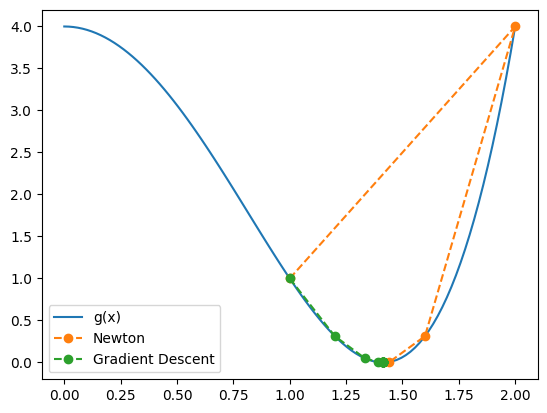

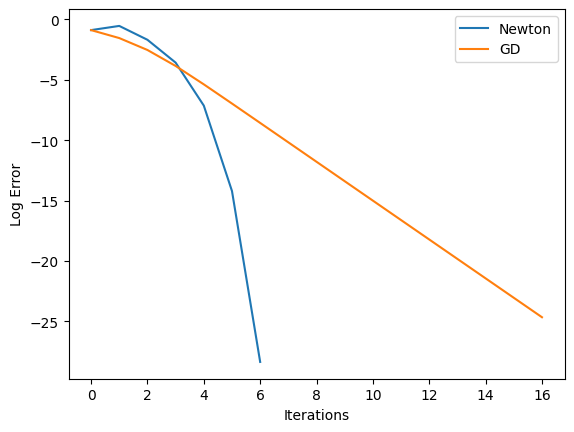

In [8]:

plt.plot(X,Y,label="g(x)")
tol = 1e-10
m1 = NewtonsMethod(dg,d2g, 1, tol=tol, log=True)
plt.plot(m1,list(map(g,m1)),label="Newton",linestyle='--', marker='o')

step = lambda x,t,df: 0.05
m2 = GradientDescent(dg,step,1, tol=tol, log=True)
plt.plot(m2,list(map(g,m2)),label="Gradient Descent",linestyle="--",marker="o")

plt.legend()
plt.show()

L = lambda X: list(range(len(X)))
plt.plot(L(m1[:-1]),np.log(np.abs(m1-np.sqrt(2))[:-1]), label="Newton")
plt.plot(L(m2),np.log(np.abs(m2-np.sqrt(2))), label="GD")
plt.xlabel("Iterations")
plt.ylabel("Log Error")
plt.legend()
plt.show()

### Multivariable Optimization

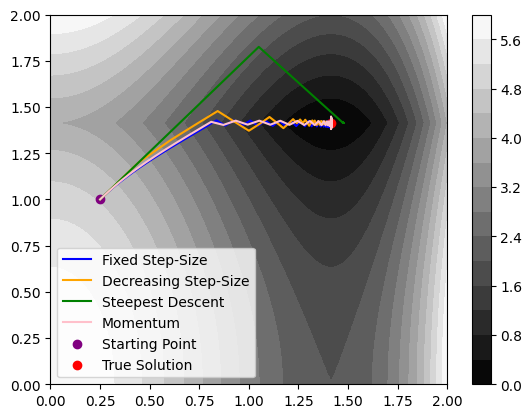

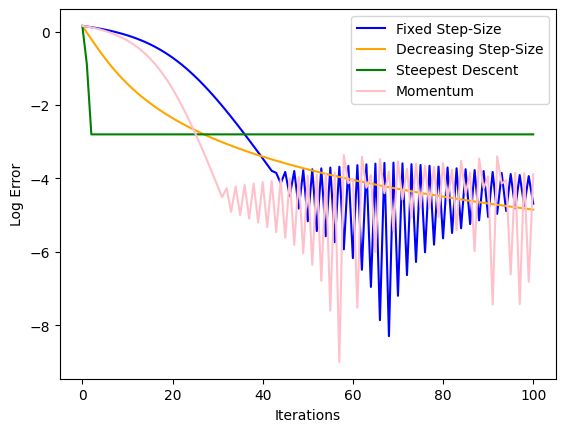

In [9]:
# multivariable gradient descent:
k = lambda x: g(x[0]) + g(x[1])**0.5
dk = lambda x: np.array([dg(x[0]), 0.5*g(x[1])**(-0.5)*dg(x[1])])
d2k = lambda x: np.array([[d2g(x[0]), 0],
                          [0, -0.25*g(x[1])**(-1.5)*dg(x[1])**2 + 0.5*g(x[1])**(-0.5)*d2g(x[1])]])
step = lambda x,t,df: 0.1/(t+1)
step2 = lambda x,t,df: 0.01
step3 = lambda x,t,df: SteepestDescent(x,t,k,df,2)
start=[0.25,1]

# calculate paths for each algorithm
m3 = GradientDescent(dk,step,start, tol=tol, log=True)
m4 = GradientDescent(dk,step2,start, tol=tol, log=True)
m5 = GradientDescent(dk,step3,start, tol=0, log=True)
m6 = GradientDescent(dk,step2,start, tol=tol, log=True, momentum=0.3)

# create visualization of function
xx,yy = np.meshgrid(X,X)
zz = np.array(list(map(g,xx))) + np.sqrt(list(map(g,yy)))
plt.contourf(xx,yy,zz,15, cmap="gray")
plt.colorbar()

# add algorithms
plt.plot(m4[:,0],m4[:,1], label="Fixed Step-Size", color="blue")
plt.plot(m3[:,0],m3[:,1], label="Decreasing Step-Size", color="orange")
plt.plot(m5[:,0],m5[:,1], label="Steepest Descent", color="green")
plt.plot(m6[:,0],m6[:,1], label="Momentum", color="pink")
plt.scatter([start[0]],[start[1]],color="purple",label="Starting Point")
plt.scatter([np.sqrt(2)],[np.sqrt(2)],label="True Solution",color="red")

plt.legend()
plt.show()

# Visualize error
plt.plot(L(m4),np.log(np.apply_along_axis(np.max, 1, np.abs(m4-np.sqrt([2,2])))),label="Fixed Step-Size", color="blue")
plt.plot(L(m3),np.log(np.apply_along_axis(np.max, 1, np.abs(m3-np.sqrt([2,2])))),label="Decreasing Step-Size",color="orange")
plt.plot(L(m5),np.log(np.apply_along_axis(np.max, 1, np.abs(m5-np.sqrt([2,2])))),label="Steepest Descent",color="green")
plt.plot(L(m6),np.log(np.apply_along_axis(np.max, 1, np.abs(m6-np.sqrt([2,2])))),label="Momentum", color="pink")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Log Error")
plt.show()

# Numerical Methods

## Root Finding (1D)
I again approximate $\sqrt{2}$ using $g(x)=x^2-2$.  The methods are compared theoretically using Q-order convergence.  A method producing a sequence ${x_n}$ has Q-order convergence $s\ge1$ if $$\lim_{n\rightarrow\infty}\frac{|x_n-x^*|}{|x_{n-1}-x^*|^s}=c$$ for $c\in(0,\infty)$.

In [10]:
g = lambda x: x**2 - 2
dg = lambda x: 2*x

### Fixed Point Iteration (FPI)

In [11]:
def FPI(f,alpha,x0,tol=0,N=100,log=False):
  x,x0 = x0,math.inf
  iter = 0
  past = [x]
  while abs(x-x0) > tol and iter < N:
    x0 = x
    x = x - alpha*f(x)
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)


### Newton's Method
Requires the derivative of the function.  Converges quadratically.

In [12]:
def NewtonRoot(f,df,x0,tol=0,N=100,log=False):
  x,x0 = x0,math.inf
  iter = 0
  past = [x]
  while abs(x-x0) > tol and iter < N:
    x0 = x
    x = x - f(x)/df(x)
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)



### Secant Method
Similar to Newton's method but doesn't require the derivative.  Converges with rate $\frac{1+\sqrt5}2$ (golden ratio).

In [13]:
def SecantRoot(f,x0,tol=0,N=100,log=False):
  x=x0+0.001
  iter = 0
  past = [x]
  while abs(x-x0) > tol and iter < N:
    try:
      x1 = x - f(x)*(x-x0) / (f(x)-f(x0))
      x,x0 = x1,x
    except ZeroDivisionError: pass
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)


### Steffensen's Method
For linearly convergent methods, Aitken Acceleration increases the rate of convergence to a value less than 2.  Using this on fixed point iteration gives Steffensen's Method.


In [14]:
def Steffensen(f, x0, tol=0, N=100, log=False):
  x,x0 = x0,math.inf
  past = [x]
  iter=0
  while abs(x-x0) > tol and iter < N:
    x0=x
    try: x = x - f(x)**2 / (f(x + f(x)) - f(x))
    except ZeroDivisionError: pass
    iter += 1
    if log: past.append(x)
  return x if not log else np.array(past)


### Comparision
I plot the errors against the square root of 2:

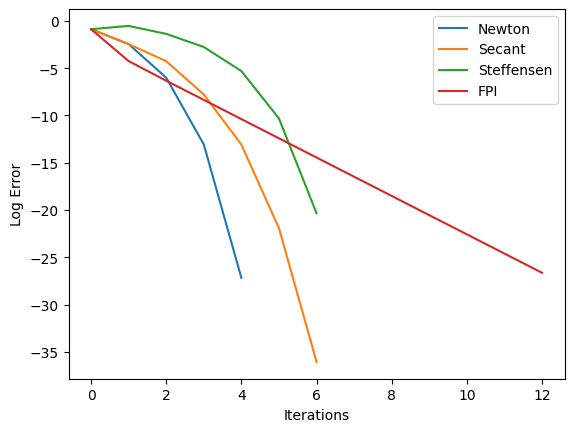

In [15]:
L = lambda X: list(range(len(X)))

tol=1e-10
r1 = np.log(np.abs(NewtonRoot(g,dg,1,tol=tol,log=True)-np.sqrt(2))[:-1])
r2 = np.log(np.abs(SecantRoot(g,1,tol=tol,log=True)-np.sqrt(2))[:-1])
r3 = np.log(np.abs(Steffensen(g,1,tol=tol,log=True)-np.sqrt(2))[:-2])
r4 = np.log(np.abs(FPI(g,0.4,1,tol=tol,log=True)-np.sqrt(2)))

plt.plot(L(r1),r1,label="Newton")
plt.plot(L(r2),r2,label="Secant")
plt.plot(L(r3),r3,label="Steffensen")
plt.plot(L(r4),r4,label="FPI")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Log Error")
plt.show()

## Numerical Linear Algebra

In [16]:
def systemError(x,A,b):
  return ((A.dot(x)-b)**2).sum()**0.5

def norm2(x,y):
  return ((x-y)**2).sum()**0.5

### Gaussian Elimination
This is what everybody learns in linear algebra, but it is inefficient for large matrices.

In [17]:
def gaussian_elimination(A,b):
    A = A.copy()
    b = b.copy()
    for i in range(A.shape[1]):
        b[i] = b[i] / A[i,i]
        A[i,:] =  A[i,:]/A[i,i]
        if i < A.shape[1]-1:
            for j in range(i+1,A.shape[1]):
                b[j] = b[j] - A[j,i] * b[i]
                A[j,:] -= A[j,i] * A[i,:]
    for i in range(A.shape[1]-2,-1,-1):
        for j in range(i+1,A.shape[1]):
            b[i] = b[i] - A[i,j]*b[j]
            A[i,:] = A[i,:] - A[i,j] * A[j,:]
    return b

### Jacobi's Method
An iterative method for solving linear systems of equations.

In [18]:
def diagonal(A):
  return np.diag(np.diagonal(A))


def Jacobi(A, b, N=100, tol=0, log=False):
    n = len(A)
    A2 = diagonal(A)
    A2inv = np.zeros([n,n])
    A2inv[np.diag_indices(n)] = np.reciprocal(A2[np.diag_indices(n)])
    A1 = A - A2
    x = np.zeros(n)
    past = [x]
    count = 0
    while systemError(x,A,b) > tol and count < N:
        x = A2inv.dot(b-A1.dot(x))
        count += 1
        if log: past.append(x)
    return x if not log else np.array(past)

### Gauss-Seidel


In [19]:
def GaussSeidel(A, b, N=100, tol=0, log=False):
    n = len(A)
    x = np.zeros(n)
    past = [x]
    count = 0
    while systemError(x,A,b) > tol and count < N:
        xk = np.zeros(n)
        for i in range(n):
            s1 = sum([A[i,j]*xk[j] for j in range(i)])
            s2 = sum([A[i,j]*x[j] for j in range(i+1,n)])
            xk[i] = 1/A[i,i]*(b[i] - s1 - s2)
        x = xk
        if log: past.append(xk)
        count += 1
    return x if not log else np.array(past)


### Successive Over-Relaxation

In [20]:
def SOR(A, b, w, N=100, tol=0, log=False):
    n = len(A)
    x = np.zeros(n)
    past = [x]
    count = 0
    while systemError(x,A,b) > tol and count < N:
        xk = np.zeros(n)
        for i in range(n):
            s1 = sum([A[i,j]*xk[j] for j in range(i)])
            s2 = sum([A[i,j]*x[j] for j in range(i+1,n)])
            xk[i] = w/A[i,i]*(b[i] - s1 - s2) + (1-w)*x[i]
        x = xk
        if log: past.append(xk)
        count += 1
    return x if not log else np.array(past)


### Comparison
Here I use a 5x5 matrix $A$ with image vector $b$ and solve for the true solution $(1,2,3,4)$ to this system.  I also record the time each method takes to solve.

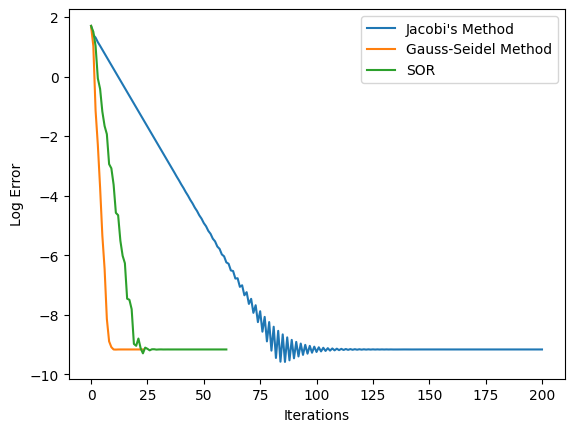

In [21]:
A = np.array([[2.4117,0.6557,0.6787,0.6555],
              [0.9157,1.8804,0.7577,0.1712],
              [0.7922,0.8491,3.0905,0.7060],
              [0.9595,0.9340,0.3922,2.3175]])
b = np.array([8.3813,7.6345,14.5862,13.2743])

tol = 1e-13

true = np.array([1,2,3,4])
trueError = lambda x: ((x-true)**2).sum()**0.5

X = Jacobi(A,b, N=200, tol=tol, log=True)
eJ = np.log(np.apply_along_axis(trueError, 1, X))

X = GaussSeidel(A,b,N=200, tol=tol, log=True)
eG = np.log(np.apply_along_axis(trueError, 1, X))

X = SOR(A,b,1.5,N=200,tol=tol,log=True)
eS = np.log(np.apply_along_axis(trueError, 1, X))

plt.plot(L(eJ), eJ, label="Jacobi's Method")
plt.plot(L(eG), eG, label="Gauss-Seidel Method")
plt.plot(L(eS), eS, label="SOR")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Log Error")
plt.show()

## Root Finding (Multivariate)

### Newton's Method
This method requires the inverse of the Jacobian.  I implemented the method to use numpy's linear system solver by default, previous methods such as Jacobi's method can be used instead.

In [22]:
def NewtonMulti(F, J, x0, solver=np.linalg.solve, N=100, tol=0, log=False):
  x0 = np.array(x0)
  x,x0 = x0, math.inf*x0
  past = [x]
  count = 0
  while norm2(x,x0) > tol and count < N:
    x0 = x
    x = x - solver(J(x),F(x))
    if log: past.append(x)
    count += 1
  return x if not log else np.array(past)


### Fixed Point Iteration

In [23]:
def FPIMulti(F, alpha, x0, N=100, tol=0, log=False):
  x0 = np.array(x0)
  x,x0 = x0,math.inf*x0
  past=[x]
  count = 0
  while norm2(x,x0) > tol and count < N:
    x0 = x
    x = x - alpha*F(x)
    if log: past.append(x)
    count += 1
  return x if not log else np.array(past)

### Comparison
The below compares FPI with Newton's method, using both numpy's solver and the Gauss-Seidel method from above with 10 iterations.  In the plots, both uses of Newton's method are indistinguishable.

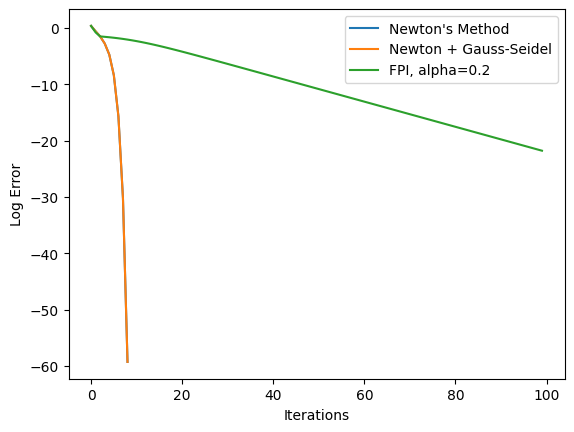

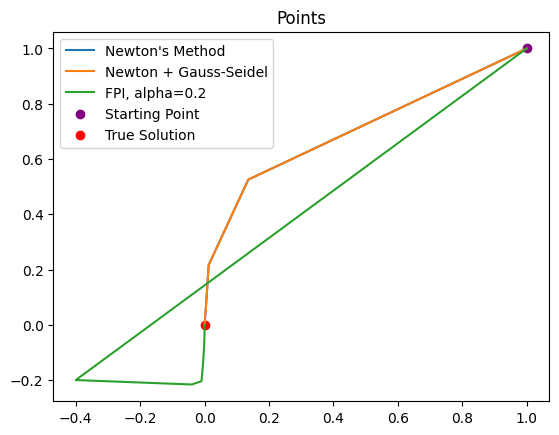

In [24]:
F = lambda x: np.array([x[0]**2 + x[1]**2 + 5*x[0], 2*x[0]*x[1] + 3*x[1]**2 + x[1]])
J = lambda x: np.array([[2*x[0] + 5, 2*x[1]],
                            [2*x[1], 2*x[0] + 6*x[1] + 1]])

tol = 1e-10
xN = NewtonMulti(F, J, (1,1),tol=tol,log=True)
xF = FPIMulti(F,0.2,(1,1),tol=tol,log=True)
xNG = NewtonMulti(F, J, (1,1), tol=tol, log=True, solver=lambda A,b: GaussSeidel(A,b,N=10))

eN = np.log(np.apply_along_axis(lambda x: norm2(np.zeros(2),x), 1,xN))
eF = np.log(np.apply_along_axis(lambda x: norm2(np.zeros(2),x), 1,xF))
eNG = np.log(np.apply_along_axis(lambda x: norm2(np.zeros(2),x), 1,xNG))

plt.plot(L(xN), eN, label="Newton's Method")
plt.plot(L(xNG),eNG,label="Newton + Gauss-Seidel")
plt.plot(L(xF), eF, label="FPI, alpha=0.2")

plt.legend()
plt.ylabel("Log Error")
plt.xlabel("Iterations")
plt.show()

plt.plot(xN[:,0],xN[:,1], label="Newton's Method")
plt.plot(xNG[:,0],xNG[:,1],label="Newton + Gauss-Seidel")
plt.plot(xF[:,0],xF[:,1], label="FPI, alpha=0.2")

plt.scatter([1],[1],color="purple",label="Starting Point")
plt.scatter([0],[0],color="red",label="True Solution")
plt.legend()
plt.title("Points")
plt.show()

## Polynomial Interpolation

### Lagrange Basis

In [25]:
# Lagrange basis:
def LagrangeBasisFn(nodes,i:int,x):
  n = len(nodes)
  return np.array([(x-nodes[j])/(nodes[i]-nodes[j]) for j in range(n) if j!=i]).prod()

def ChebyshevNodes(a,b,n):
  nodes = np.sort(np.cos(np.linspace(0,math.pi,n)))
  return 0.5*((b-a)*nodes + a+b)

def LagrangePoly(f, nodes, x):
  f_eval = np.apply_along_axis(f,0,nodes)
  l_eval = np.array(list(map(lambda i: LagrangeBasisFn(nodes,i,x), range(len(nodes)))))
  return f_eval.dot(l_eval)

### Piecewise Linear Interpolant

In [26]:
def PiecewiseLinear(f,nodes,x):
  # make sure nodes are sorted first!
  i = np.argmax(nodes[1:] > x)
  if (nodes[1:]>x).sum() == 0: i = len(nodes)-2
  return (f(nodes[i+1])-f(nodes[i]))/(nodes[i+1]-nodes[i]) * (x-nodes[i]) + f(nodes[i])



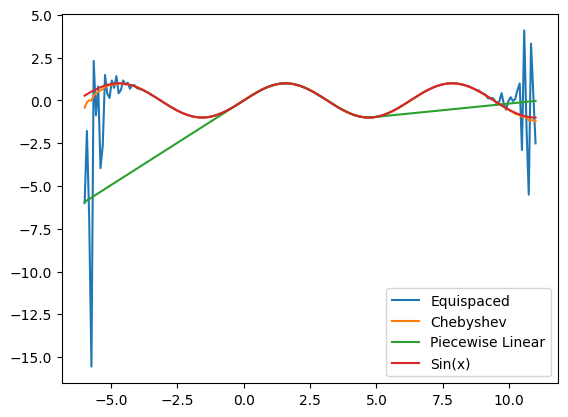

In [27]:
f = lambda x: np.sin(x)
X = np.linspace(0,5,20)
X2 = ChebyshevNodes(0,5,20)
X_plot = np.linspace(-6,11,200)
Y = list(map(lambda x: LagrangePoly(f,X,x),X_plot))
Y2 = list(map(lambda x: LagrangePoly(f,X2,x),X_plot))
Y3 = list(map(lambda x: PiecewiseLinear(f,X,x),X_plot))
Y_real = np.apply_along_axis(f,0,X_plot)
plt.plot(X_plot, Y, label="Equispaced")
plt.plot(X_plot, Y2, label="Chebyshev")
plt.plot(X_plot, Y3, label="Piecewise Linear")
plt.plot(X_plot, Y_real, label="Sin(x)")
plt.legend()
plt.show()

## Differentiation

### Finite Differences
The following three functions implement common differentiation formulas: Forward Difference, Backward Difference, and Centered Difference approximation respectively.

Forward Difference:
$$f'(x)=\frac{f(x+h)-f(x)}{h}+\mathcal{O}(h)$$

Backward Difference:
$$f'(x)=\frac{f(x)-f(x-h)}{h}+\mathcal{O}(h)$$

Centered Difference:
$$f'(x)=\frac{f(x-h)-2f(x)+f(x+h)}{h^2}+\mathcal{O}(h^2)$$

In [28]:
def ForwardDiff(f, x, h=1e-4):
  return (f(x+h) - f(x))/h

def BackwardDiff(f, x, h=1e-4):
  return (f(x) - f(x-h))/h

def CenteredDiff(f,x,h=1e-4):
  return (f(x-h) - 2*f(x) + f(x+h))/h**2


Taylor's Theorem can be used to derive more precise differentiation formulas for functions that are sufficiently smooth.  Below I derive and implement formulas for $n$ backward differences:

Taylor's Theorem directly gives that
$$f(x-h)=\sum_{i=0}^m\frac{(-h)^i}{i!}f^{(i)}(x)+\frac{(-h)^{m+1}}{(m+1)!}f^{(m+1)}(\zeta)$$
for some $\zeta\in(x-h,x)$.  Similarly, for $k\in\mathbb{N}$,
$$f(x-kh)=\sum_{i=0}^m\frac{(-kh)^i}{i!}f^{(i)}(x)+\frac{(-kh)^{m+1}}{(m+1)!}f^{(m+1)}(\zeta_k)$$

The goal is to combine the first $n$ of these formulas such that all terms after the first derivative (except for the error) cancel out.  This will give a formula for $f'(x)$ using evaluations of $f$ at multiple points, plus a higher-order error term $\mathcal{O}(h^{m})$.  By assigning each formula a coefficient $c_k$, we can solve for the needed coefficients with the following linear system of equations:

$$\begin{bmatrix}
-hf'(x) & -2hf'(x) & \dots & -nhf'(x) \\
\frac{h^2}2f''(x) & \frac{4h^2}2f''(x) & \dots & \frac{n^2h^2}2f''(x) \\
\dots & \dots & \dots & \dots \\
\frac{(-h)^m}{m!}f^{(m)}(x) & \frac{(-2h)^m}{m!}f^{(m)}(x) & \dots & \frac{(-nh)^m}{m!}f^{(m)}(x)
\end{bmatrix}\begin{bmatrix}
c_1 \\ c_2 \\ \dots \\ c_n
\end{bmatrix}=\begin{bmatrix}
1\\0\\\dots\\0
\end{bmatrix}$$

Which can be simplified to

$$\begin{bmatrix}
1&2&\dots&n\\
1&2^2&\dots&n^2\\
\dots&\dots&\dots&\dots\\
1&2^m&\dots&n^m
\end{bmatrix}\begin{bmatrix}
c_1\\c_2\\\dots\\c_n
\end{bmatrix}=\begin{bmatrix}
1\\0\\\dots\\0
\end{bmatrix}$$

The columns are linearly independent, and the system can be solved uniquely for $m=n$.  Notice that these coefficients only depend on $n$ and can thus be solved without $f$ or $h$.  I use Gaussian elimination in my implementation since $n$ is typically small and iterative methods aren't needed.  Multiplying each formula by its coefficient and summing gives

$$\sum_{i=1}^nc_if(x-ih)=f(x)\sum_{i=1}^nc_i-hf'(x)+\sum_{i=1}^n\frac{(-ih)^{n+1}c_i}{(n+1)!}f^{(n+1)}(\zeta_i)\\
\Downarrow\\
f'(x)=\frac1h\left[f(x)\sum_{i=1}^nc_i-\sum_{i=1}^nc_if(x-ih)\right]+\mathcal{O}(h^n)
$$

In [29]:
def BackwardsDiff(n):
  # Create the matrix shown above
  coef_mat = [np.arange(1,n+1)]
  for i in range(2,n+1):
    coef_mat.append(coef_mat[0] * coef_mat[-1])
  coef_mat = np.array(coef_mat)

  # Create the vector
  result_v = np.zeros(n)
  result_v[0] = 1

  # Solve for the coefficients
  coef_v = gaussian_elimination(coef_mat, result_v)

  # Return a function that gives the derivative based on the formula
  # The returned function takes inputs f, x, and h
  return lambda f, x, h=1e-4: 1/h*(f(x)*coef_v.sum() - coef_v.dot(np.array(list(map(f, x-h*np.arange(1,n+1))))))



We can test the method on a known derivative.  For this example, I use $f(x)=e^x$ evaluated at 0.  The derivative here is clearly 1.  I plot the log errors for forward difference and numerous orders of backward difference approximation.

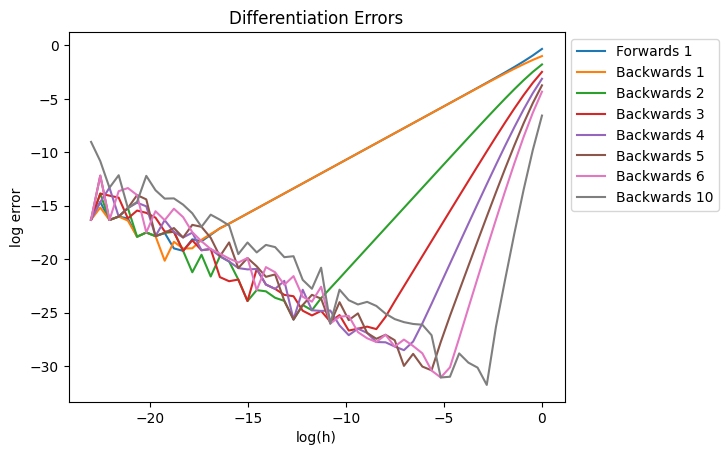

In [30]:
# Set the function f, point of evaluation z, and true derivative value
f = lambda x: math.e**x
z = 0
true = 1

# Define the values of h to test
H = 10**np.linspace(0,-10,50)

# Evaluate using forward difference
forward = np.log(np.abs(list(map(lambda h: true-ForwardDiff(f,z,h), H))))
plt.plot(np.log(H), forward, label="Forwards 1")

# Evaluate using backward differences, using 1-6 orders
backwards = []
for j in list(range(1,7))+[10]:
  fp = BackwardsDiff(j) # calculate coefficients, give formula
  backwards.append(np.log(np.abs(list(map(lambda h: true-fp(f,z,h),H)))))
  plt.plot(np.log(H), backwards[-1], label=f"Backwards {j}")

# Alter plot appearance
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("log(h)")
plt.ylabel("log error")
plt.title("Differentiation Errors")
plt.show()




Note that values further to the left represent smaller values of $h$.  When $h$ is still somewhat large, we can see that higher orders of backward difference approximations converge more rapidly to the true derivative of 1.  At a small enough interval, each method begins to lose accuracy from floating point error.  While this occurs sooner for the higher-order methods, their peak accuracy is still greater than the others'.  For the method with 6 backwards differences, the optimal value of $h$ would be around $e^{-5}$.  The method with only 1 backwards difference would be optimized at roughly $h=e^{-18}$ with error larger by a factor of $e^{11}$.  The order 10 method shows the decreasing marginal benefit as the orders increase.  For even higher orders, such as 15, the methods begin to break down.

### Polynomial Interpolant

In [31]:
def LagrangeBasisFnDiff(nodes, i, x):
  n = len(nodes)
  return np.array([1/(nodes[i]-nodes[j])*np.array([(x-nodes[k])/(nodes[i]-nodes[k]) for k in range(n) if k!=j and k!=i]).prod() for j in range(n) if j!=i]).sum()


def LagrangePolyDiff(f, nodes, x):
  f_eval = np.apply_along_axis(f,0,nodes)
  lp_eval = np.array(list(map(lambda i: LagrangeBasisFnDiff(nodes,i,x), range(len(nodes)))))
  return f_eval.dot(lp_eval)

<ipython-input-32-c6bb0d2adc7a>:16: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(ns), np.log(np.abs(true-np.array(equi_diff))), label="Equispaced")


[]

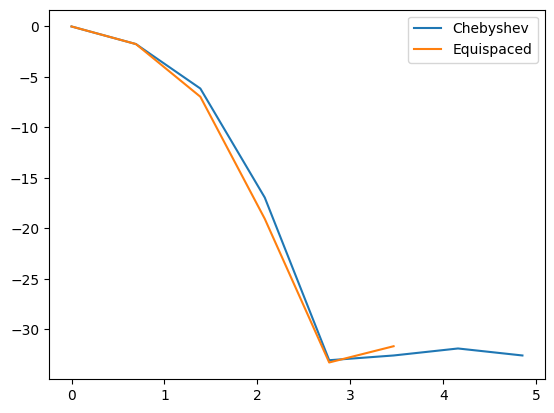

In [32]:
f = lambda x: math.e**x
z = 0
true = 1

cheby_diff = []
equi_diff = []

ns = 2**np.arange(0,8)

for n in ns:
  n = int(n)
  cheby_diff.append(LagrangePolyDiff(f, ChebyshevNodes(-1,1,n),z))
  equi_diff.append(LagrangePolyDiff(f,np.linspace(-1,1,n),z))

plt.plot(np.log(ns), np.log(np.abs(true-np.array(cheby_diff))), label="Chebyshev")
plt.plot(np.log(ns), np.log(np.abs(true-np.array(equi_diff))), label="Equispaced")
plt.legend()
plt.plot()

<ipython-input-33-91a8a972ee1a>:2: RuntimeWarning: overflow encountered in power
  f = lambda x: math.e**x
<ipython-input-33-91a8a972ee1a>:15: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(H), np.log(np.abs(true-np.array(cheby_diff))), label="Chebyshev")


[]

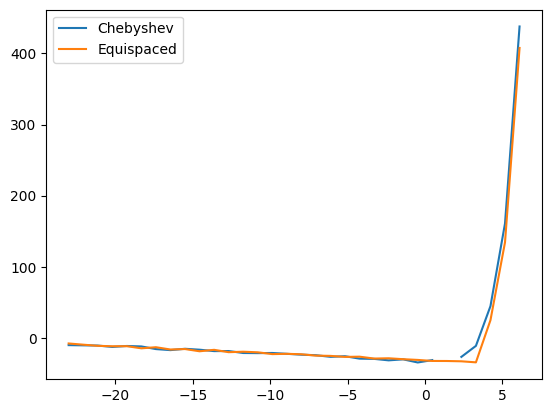

In [33]:
# interval size instead of nodes:
f = lambda x: math.e**x
z = 0
true = 1

cheby_diff = []
equi_diff = []

H = 10**np.linspace(10,-10,50)

for h in H:
  cheby_diff.append(LagrangePolyDiff(f, ChebyshevNodes(z-h,z+h,50),z))
  equi_diff.append(LagrangePolyDiff(f,np.linspace(z-h,z+h,50),z))

plt.plot(np.log(H), np.log(np.abs(true-np.array(cheby_diff))), label="Chebyshev")
plt.plot(np.log(H), np.log(np.abs(true-np.array(equi_diff))), label="Equispaced")
plt.legend()
plt.plot()

## Quadrature
Want to approximate $\int_a^bf(x)dx$

### Trapezoid Rule

#### Regular:
Approximates the integral using a linear interpolant.
$$\begin{aligned}
\int_a^bf(x)dx&\approx \int_a^b\left[f(a)\left(\frac{x-b}{a-b}\right)+f(b)\left(\frac{x-a}{b-a}\right)\right]dx\\
&=\left(\frac{b-a}2\right)(f(a)+f(b))
\end{aligned}$$

This method has error $-\frac1{12}f''(\zeta)(b-a)^3$ for some $\zeta\in(a,b)$.

In [34]:
def trapezoid(f,a,b):
  return (b-a)/2*(f(a)+f(b))

#### Composite:
Dividing $[a,b]$ into $n$ subintervals of length $h=\frac{b-a}n$:

$$\begin{aligned}
\int_a^bf(x)dx&=\sum_{i=0}^{n-1}\int_{x_i}^{x_{i+1}}f(x)dx\\
&\approx\sum_{i=0}^{n-1}\left(\frac{x_{i+1}-x_i}2\right)(f(x_i)+f(x_{i+1}))\\
&=\frac{h}2\sum_{i=0}^{n-1}(f(x_{i+1})-f(x_i))\\
&=\frac{h}2(f(x_0)+2\sum_{i=1}^{n-1}f(x_i)+f(x_n))
\end{aligned}$$

This method has error $-\frac1{12}h^2(b-a)f''(\zeta)$ for some $\zeta\in(a,b)$.

In [35]:
def compositeTrapezoid(f,a,b,n):
  X = np.linspace(a,b,n+1)
  s1 = np.apply_along_axis(f, 0, X[1:-1]).sum()
  return (b-a)/n * (f(a) + 2*s1 + f(b))

### Simpson's Rule


#### Regular:
Approximates the integral using a quadratic interpolant.

Let $x_0=a,x_2=b$, and $x_1$ be their midpoint.
$$\int_{x_0}^{x_2}f(x)dx\approx \frac{h}3(f(x_0)+4f(x_1)+f(x_2))$$

This method has error $-\frac{h^5}{12}(\frac13f^{(4)}(\zeta_1)-\frac15f^{(4)}(\zeta_2))$ for some $\zeta_1,\zeta_2\in(a,b)$.

In [36]:
def simpson(f,a,b):
  x1 = (a+b)/2
  return (b-a)/6 * (f(a) + 4*f(x1) + f(b))

#### Composite:
$$\begin{aligned}
\int_a^bf(x)dx&\approx\sum_{j=1}^{\frac{n}2}\frac{h}3(f(x_{2j-2})+4f(x_{2j-1})+f(x_{2j}))\\
&=\frac{h}3\left(f(x_0)+4\sum_{j=1}^{\frac{n}2}f(x_{2j-1})+2\sum_{j=1}^{\frac{n}2-1}f(x_{2j})+f(x_n)\right)
\end{aligned}$$
This method has error $\frac{-(b-a)}{180}h^4f^{(4)}(\zeta)$ for some $\zeta\in(a,b)$.

In [37]:
def compositeSimpson(f,a,b,n):
  X = np.linspace(a,b,2*n+1)
  s1 = np.apply_along_axis(f,0,X[1:-1:2]).sum()
  s2 = np.apply_along_axis(f,0,X[2:-2:2]).sum()
  return (b-a)/(2*n) * (f(a) + 4*s1 + 2*s2)


## Fourier Transform

## Differential Equations